# 1. Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

2025-01-08 06:36:44.202422: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 06:36:44.202566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 06:36:44.381182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Setting Up the Dataset Path

In [2]:
# Path to the data folder containing train and test folders

data_folder ='/kaggle/input/firedetection'

# Explore dataset structure
folders = os.listdir(data_folder)
class_names = os.listdir(os.path.join(data_folder,folders[-1]))
#class_names.remove('.DS_Store')

print(class_names)

['0', '1']


# 3. Loading and Preprocessing the Dataset

In [3]:
images = []
labels = []
for folder in folders:
    folder_path = os.path.join(data_folder, folder)
    for class_index, class_name in enumerate(class_names):
        class_folder_path = os.path.join(folder_path, class_name)
        print(class_folder_path)
        if class_folder_path.find(".DS") != -1:
          continue
        for filename in os.listdir(class_folder_path):
            if filename.endswith('.jpg'):
                img = load_img(os.path.join(class_folder_path, filename), target_size=(224, 224))
                img_arr = img_to_array(img)
                images.append(img_arr)
                labels.append(class_index)

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

/kaggle/input/firedetection/Fire-Detection/0
/kaggle/input/firedetection/Fire-Detection/1


# 4. Splitting and Normalizing the Dataset

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=4)

# Scale the pixel values to a range between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0
X_test.shape[0]

125

# 5. Visualizing Sample Images

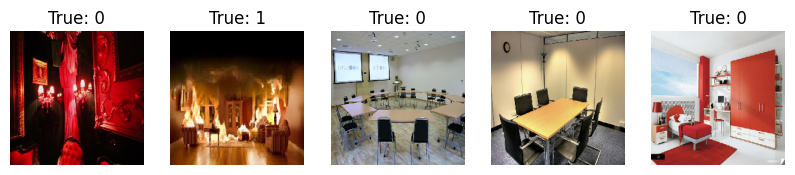

In [5]:
# Display sample images at the beginning
sample_images = X_test[:5]  # Change the number to display more or fewer images
sample_labels = y_test[:5]

plt.figure(figsize=(10, 5))
for i in range(len(sample_images)):
    plt.subplot(1, len(sample_images), i + 1)
    plt.imshow(sample_images[i].reshape(224, 224, 3))
    plt.title(f'True: {class_names[sample_labels[i]]}')
    plt.axis('off')
plt.show()

# 6. Encoding Labels

In [6]:
#to encode labels into numerics
def convert(array):
  encoded = []
  for i in array:
    column  =[0] * len(class_names)
    column[i] = 1
    encoded.append(column)
  return np.array(encoded)

y_train = convert(y_train)
y_test = convert(y_test)

In [7]:
X_train.shape, y_train.shape , X_test.shape, y_test.shape

((499, 224, 224, 3), (499, 2), (125, 224, 224, 3), (125, 2))

In [8]:
y_train[1]

array([1, 0])

# 7. Building the CNN Model

In [9]:
# Build the MLP model
model = Sequential()
inputshape = X_train.shape[1:]
#model.add(Input(shape = X_train.shape[1:],))

model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=inputshape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape=inputshape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))  # Use softmax activation for multi-class classification

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,915,778 (91.23 MB)

 Trainable params: 23,915,778 (91.23 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Compiling the Model and Training the Model

In [10]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 969ms/step - accuracy: 0.7509 - loss: 2.2387 - val_accuracy: 0.8560 - val_loss: 0.3022
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 985ms/step - accuracy: 0.8509 - loss: 0.3111 - val_accuracy: 0.8480 - val_loss: 0.2720
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9162 - loss: 0.1940 - val_accuracy: 0.9200 - val_loss: 0.2228
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 993ms/step - accuracy: 0.9551 - loss: 0.1089 - val_accuracy: 0.9120 - val_loss: 0.2885
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 992ms/step - accuracy: 0.9763 - loss: 0.0951 - val_accuracy: 0.8880 - val_loss: 0.3457
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 974ms/step - accuracy: 0.9996 - loss: 0.0191 - val_accuracy: 0.8640 - val_loss: 0.5242
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 970ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.8240 - val_loss: 0.5285
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 960ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accurac

# 9. Evaluating the Model and Predicting Test Set Labels

In [11]:
# Calculating only Test Set Accuracy of the Model
loss, accuracy = model.evaluate(X_test, y_test)

#print(%.3f"Accuracy : {accuracy}")
print('Accuracy : %.3f' % accuracy)

y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis =1)
New_y_test = np.argmax(y_test, axis =1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 468ms/step - accuracy: 0.8521 - loss: 0.5353
Accuracy : 0.888
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step


# 10. Confusion Matrix and Metrics

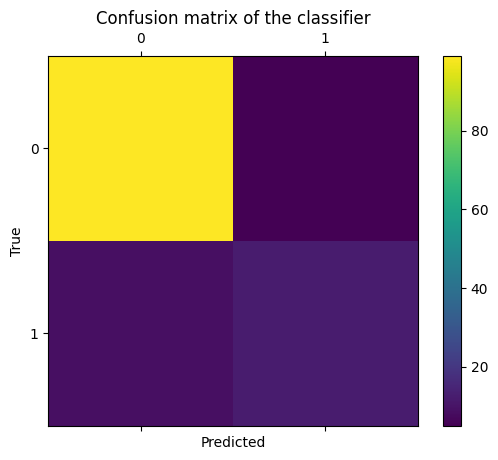

Accuracy :0.888
0.8113 0.7617 0.7828


In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

cm = confusion_matrix(New_y_test, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("Accuracy :" + str(round(accuracy_score(New_y_test, y_pred),4)))
p, r, f, s = precision_recall_fscore_support(New_y_test, y_pred, average='macro')
print(round(p,4),round(r,4),round(f,4))

# 11. Visualizing Predictions on Test Set

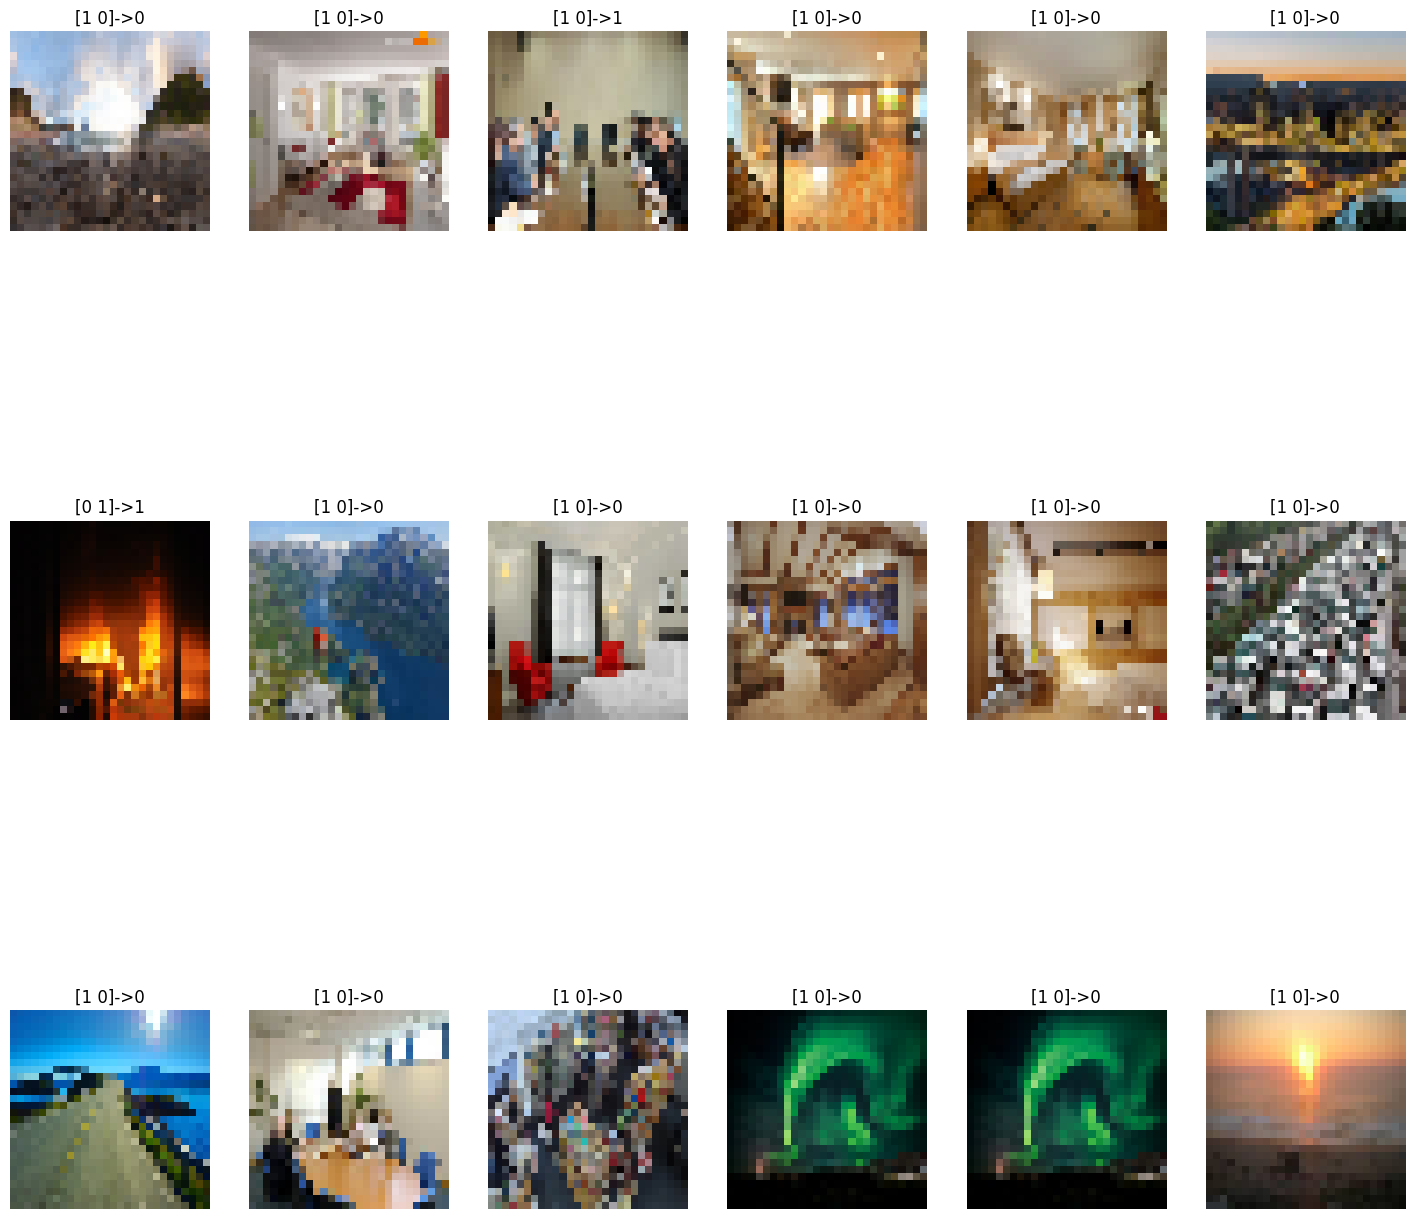

In [13]:
#Visualising the Fire Dataset Samples
import cv2

plt.figure(figsize=(18, 18))
for i in range(18):
  plt.subplot(3, 6, i + 1)
  fignum = np.random.randint(1, high=100)
  plt.imshow(cv2.resize(X_test[fignum], (28, 28)))
  strname = str(y_test[fignum])+"->"+str(y_pred[fignum])
  plt.title(strname)
  plt.axis("off")